In [1]:
from torchvision import models, datasets
import torch
import torchvision.transforms as T
import torch.nn.utils.prune as prune
from tqdm.notebook import tqdm

In [2]:
import sys
sys.path.insert(0, "./../")

In [3]:
from src.model import get_model_instance_segmentation
from src.test_utils import test_model_on_dataset, get_inference_time, get_model_prediction_one_image, get_model_size_mb
from src.references.detection import coco_utils
import src.references.detection.transforms as TL
from src.visual_utils import show_coco_dataset_item, show_instance_segmentation_by_model_predictions

In [4]:
COCO_ROOT_PATH = "/data"

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpu_device = torch.device("cpu")

### Load dataset

In [6]:
common_transforms = TL.Compose([TL.ToTensor()])

dataset = coco_utils.get_coco(COCO_ROOT_PATH, "val", common_transforms, dataset_len=200)

loading annotations into memory...
Done (t=0.68s)
creating index...
index created!


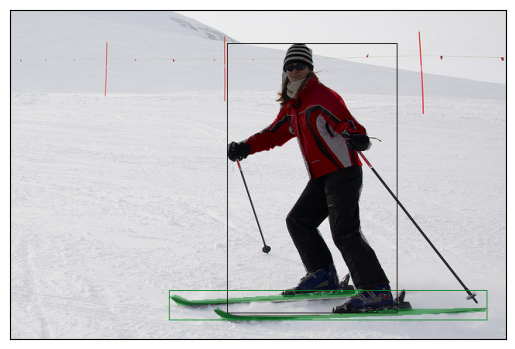

In [7]:
show_coco_dataset_item(dataset[5])

### Load model

In [11]:
model = get_model_instance_segmentation()

In [12]:
get_model_size_mb(model)

169.78314590454102

In [13]:
torch.save(model.state_dict(), "/tmp/model.pth")

In [16]:
!gzip -qf /tmp/model.pth
!du -h /tmp/model.pth.gz

158M	/tmp/model.pth.gz


In [17]:
model = model.to(device)
for name, module in model.backbone.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module, name='weight', amount=0.5)
        prune.remove(module, 'weight')

In [18]:
get_model_size_mb(model)

169.78314590454102

In [19]:
torch.save(model.state_dict(), "/tmp/model.pth")

In [20]:
!gzip -qf /tmp/model.pth
!du -h /tmp/model.pth.gz

121M	/tmp/model.pth.gz


### Test inference on one image

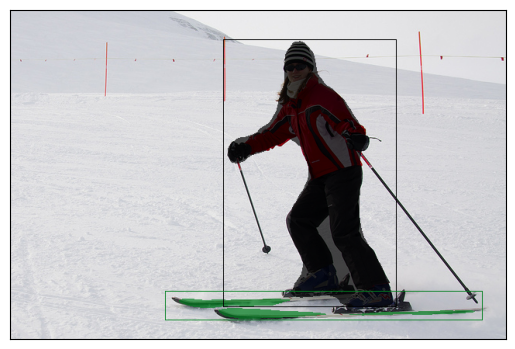

In [21]:
item_index = 5
img = dataset[item_index][0]
pred = get_model_prediction_one_image(img, model, device)
show_instance_segmentation_by_model_predictions(img, pred)

### Measure model performance

In [22]:
test_model_on_dataset(model, dataset, device)

Test:  [  0/200]  eta: 0:02:39  model_time: 0.5419 (0.5419)  evaluator_time: 0.1988 (0.1988)  time: 0.7980  data: 0.0565  max mem: 575
Test:  [199/200]  eta: 0:00:00  model_time: 0.3471 (0.3748)  evaluator_time: 0.0266 (0.0493)  time: 0.4421  data: 0.0239  max mem: 612
Test: Total time: 0:01:30 (0.4505 s / it)
Averaged stats: model_time: 0.3471 (0.3748)  evaluator_time: 0.0266 (0.0493)
Accumulating evaluation results...
DONE (t=0.81s).
Accumulating evaluation results...
DONE (t=0.68s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.530
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.340
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.230
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.369
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.495
 Average Rec

In [23]:
test_model_on_dataset(model, dataset, device, cat_ids=[1]) # person

Test:  [  0/200]  eta: 0:02:23  model_time: 0.5567 (0.5567)  evaluator_time: 0.1093 (0.1093)  time: 0.7199  data: 0.0533  max mem: 612
Test:  [199/200]  eta: 0:00:00  model_time: 0.3952 (0.4398)  evaluator_time: 0.0870 (0.1049)  time: 0.7021  data: 0.0854  max mem: 612
Test: Total time: 0:02:02 (0.6115 s / it)
Averaged stats: model_time: 0.3952 (0.4398)  evaluator_time: 0.0870 (0.1049)
Accumulating evaluation results...
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.13s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.441
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.757
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.423
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.294
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.519
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.575
 Average Rec

### Inference time

In [24]:
model = model.to(device)
model = model.eval()
total_time = 0
for i, dataset_item in tqdm(enumerate(dataset), total=len(dataset)):
    input_image = dataset_item[0]
    img = input_image.to(device)
    item_time = get_inference_time(img, model, device)
    total_time += item_time
print(f"Mean time: {total_time / len(dataset)}")

  0%|          | 0/200 [00:00<?, ?it/s]

Mean time: 0.4244714403152466
